In [2]:
import tqdm, numpy as np, matplotlib.pyplot as plt, pandas as pd, statistics as st

# Estilo mais agradável para plotar gráficos e tabelas
plt.style.use('seaborn-whitegrid')

In [3]:
def imprimirTabela(dataFrame, posicao):
    fig, ax = plt.subplots()
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    ax.table(cellText=dataFrame.values, colLabels=dataFrame.columns, rowLabels=(dataFrame.index + 1), loc=posicao)
    
    plt.show()

In [4]:
# Carregando os dados do arquivo CSV
# a primeira linha corresponde aos meses do ano
# a primeira coluna corresponde aos anos observados
#dados_csv = pd.read_csv('vazoes_maximas_teste.csv', delimiter=';', header=0, index_col=0, on_bad_lines='warn')
dados_csv = pd.read_csv('vazoes_maximas_trabalho.csv', delimiter=';', header=0, index_col=0, on_bad_lines='warn')
#dados_csv.T.plot(legend=False)

In [5]:
# Gerar o vetor para o ano hidrologico. Começa em SETEMBRO de um ano e termina em AGOSTO do ano seguinte
# Desta forma, precisa cortar parte do primeiro ano registrado e parte do último.
# Isso vai gerar um vetor com duas linhas a menos que a matriz original do CSV
#ano_hidrologico_inicio, ano_hidrologico_fim = 0, 11

# estou considerando que o ano hidrologico começa em Janeiro e termina em Dezembro
ano_hidrologico = dados_csv.to_numpy()
#plt.plot(ano_hidrologico.T)

#for i in tqdm.tqdm(range(len(dados_csv.to_numpy()) - 1)):
#    ano_hidrologico.append(np.concatenate((dados_csv.to_numpy()[i][ano_hidrologico_inicio:], dados_csv.to_numpy()[i+1][:ano_hidrologico_fim+1]), axis=None))

In [6]:
# Imprimir a matriz com os dados do ano hidrológico
#imprimirTabela(pd.DataFrame(ano_hidrologico, columns=('Set', 'Out', 'Nov', 'Dez', 'Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago')), 'center')

In [7]:
# Cria o vetor com as vazões máximas para cada ano hidrológico
q_max = [np.amax(ano_hidrologico[x]) for x in tqdm.tqdm(range(len(ano_hidrologico)))]

100%|██████████| 31/31 [00:00<00:00, 28265.96it/s]


In [8]:
# Imprimir o vetor com as vazões máximas
#imprimirTabela(pd.DataFrame(data={'Vazoes Maximas (m3/s)': q_max}), 'center')

In [9]:
# Calcular a distribuição das probabilidades

# Primeiro ordena do maior para o menor
q_max_sort = q_max.copy()
q_max_sort.sort(reverse=True)

# Calcular a PROBABILIDADE EMPIRICA
# P = index / (tamanho + 1)
prob_empirica = [(x+1)/(len(q_max_sort)+1) for x in tqdm.tqdm(range(len(q_max_sort)))]

# Calcular o TEMPO DE RETORNO
# t = 1 / P
tempo_retorno = [1/prob_empirica[x] for x in tqdm.tqdm(range(len(prob_empirica)))]

100%|██████████| 31/31 [00:00<00:00, 562871.97it/s]


In [10]:
#imprimirTabela(pd.DataFrame(data={'Q Max ordenada' : q_max_sort}), 'center')
#imprimirTabela(pd.DataFrame(data={'Prob Empirica' : prob_empirica}), 'center')
#imprimirTabela(pd.DataFrame(data={'Tempo de retorno (anos)' : tempo_retorno}), 'center')

<AxesSubplot:xlabel='Tempo de Retorno', ylabel='QMax Empírica (m3/s)'>

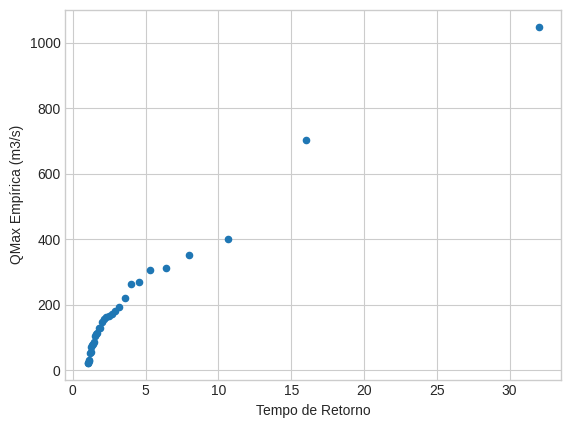

In [11]:
df_plot = pd.DataFrame({'QMax Empírica (m3/s)': q_max_sort, 'Tempo de Retorno': tempo_retorno})
df_plot.plot.scatter(x='Tempo de Retorno', y='QMax Empírica (m3/s)', grid=True)

In [12]:
#len(tempo_retorno), tempo_retorno
#len(q_max_sort), q_max_sort

In [13]:
# Gumbel

# Cálculo da vazão máxima q, para o tempo de retorno TR
# q(TR) = u - ln(-ln(1 - 1/TR))*a

# a = 0.78*s, sendo 's' o DESVIO-PADRÃO da série de vazões máximas
# u = m - 0.5772 * a, sendo 'm' a MÉDIA da série de vazões máximas

# Calculando MÉDIA e DESVIO-PADRÃO da série de vazões máximas
m, s  = st.mean(q_max), st.stdev(q_max)

# calcula o 'a'
a = 0.78 * s

# calcula o 'u'
u = m - (0.5772 * a)

# Gumbel TR
q_tr = []
gumbel_tr = [(i+1.) for i in tqdm.tqdm(range(len(q_max)))]
gumbel_tr[0] = 1.01 # essa manha tem que ser feita porque senão retorna 0 para o 'ln' e isso é matematicamente errado.
   
q_tr = [u - (np.log(-np.log(1 - 1/gumbel_tr[i])) * a) for i in tqdm.tqdm(range(len(gumbel_tr)))]

#m, s, a, u, q_tr

100%|██████████| 31/31 [00:00<00:00, 107724.46it/s]


In [14]:
#len(q_max_sort), len(gumbel_tr), len(q_tr)

100%|██████████| 62/62 [00:00<00:00, 197304.13it/s]


<AxesSubplot:title={'center':'Gumbel'}, xlabel='TR', ylabel='Vazão (m3/2)'>

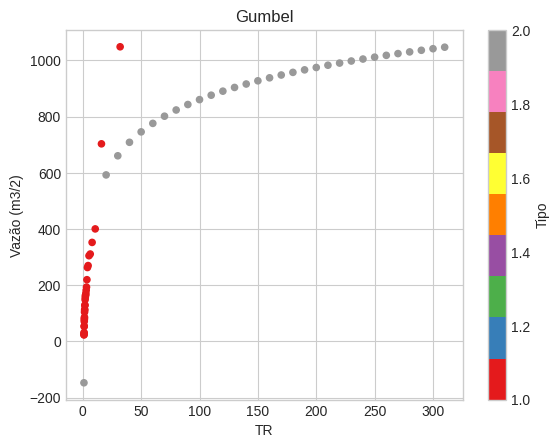

In [15]:
# Esse passo é importante para desenhar o mesmo gráfico com cores diferentes para os pontos
n_vazoes = len(q_max_sort) + len(q_tr)

#vetor_final_plot[0] = [q_max_sort[0], tempo_retorno[0], 1] <<< ISSO FUNCIONA
vetor_final_plot = []
for i in tqdm.tqdm(range(n_vazoes)):
    if (i < int(n_vazoes/2)):
        vetor_final_plot.insert(i, [q_max_sort[i], tempo_retorno[i], 1]) # Empirico
    else:
        vetor_final_plot.insert(i, [q_tr[i-int(n_vazoes/2)], gumbel_tr[i-int(n_vazoes/2)], 2]) # Gumbel

gumbel_plot = pd.DataFrame(vetor_final_plot, columns=['Vazão (m3/2)', 'TR', 'Tipo'])
#gumbel_plot = pd.DataFrame({'QMax Gumbel (m3/s)': q_tr, 'QMax Empírica (m3/s)' : q_max_sort, 'TR Gumbel': gumbel_tr, 'TR Empírico': tempo_retorno})
#imprimirTabela(gumbel_plot, 'center')
#gumbel_plot.plot(x='TR Gumbel', y=['QMax Gumbelc (m3/s)', 'QMax Empírica (m3/s)'])
gumbel_plot.plot.scatter(x='TR', y='Vazão (m3/2)', c='Tipo', colormap='Set1', title='Gumbel', grid=True)

In [15]:
(5, 2)

(5, 2)

In [16]:
# Log-Pearson T3

# Gera o vetor com LN de cada uma das vazões máximas
#log_qmax = [np.log(q_max[i]) for i in tqdm.tqdm(range(len(q_max)))]
log_qmax = np.log10(q_max)

# Para calcula a MODA
log_qmax_discreto = [int(log_qmax[i]) for i in tqdm.tqdm(range(len(log_qmax)))]

# Tira a MÉDIA, MODA e DESVIO-PADRÃO para calcular o COEFICIENTE DE ASSIMESTRIA DE PEARSON
#me, mo, sd = st.mean(log_qmax), min(st.multimode(log_qmax_discreto)), st.stdev(log_qmax)
me, mo, sd = st.mean(log_qmax), st.mode(log_qmax_discreto), st.stdev(log_qmax)
g = (me - mo) / sd

vetor_tr_pearson = [(i+1.) for i in tqdm.tqdm(range(len(q_max)))]
vetor_tr_pearson[0] = 1.01

vetor_t = [np.sqrt(2 * np.log(vetor_tr_pearson[i])) for i in tqdm.tqdm(range(len(vetor_tr_pearson)))]
vetor_k1 = [vetor_t[i] - ((2.515517+0.802853*vetor_t[i]+0.010328*np.power(vetor_t[i], 2)) / (1+1.1432788*vetor_t[i]+0.189269*np.power(vetor_t[i],2)+0.001308*np.power(vetor_t[i],3))) \
            for i in tqdm.tqdm(range(len(vetor_t)))]
vetor_k = [2/g*(np.power(((vetor_k1[i]-(g/6))*(g/6)+1),3)-1) for i in tqdm.tqdm(range(len(vetor_k1)))]

# 10^((media dos log10 das vazoes) + K*S_log10_Q)
pearson_tr = [np.power(10, (me+vetor_k[i]*sd)) for i in tqdm.tqdm(range(len(vetor_k)))]

me, mo, sd, g, log_qmax, log_qmax_discreto, vetor_t, vetor_k1, vetor_k, pearson_tr

100%|██████████| 31/31 [00:00<00:00, 268643.44it/s]


(2.1250528257818857,
 2,
 0.3996129254848828,
 0.3129348872540821,
 array([3.02060033, 2.23330077, 2.19461978, 1.50222222, 2.3417055 ,
        2.17188143, 2.28627454, 2.26010957, 1.46980729, 1.36632955,
        2.43125276, 1.7230039 , 2.01783437, 2.21689132, 2.49280926,
        2.54700386, 1.91369202, 1.74023633, 2.04399851, 1.93533593,
        2.60249081, 2.84708195, 2.10677546, 2.0568477 , 1.89160993,
        2.48422721, 2.41988474, 2.11285961, 1.85363738, 2.21273612,
        1.37957743]),
 [3,
  2,
  2,
  1,
  2,
  2,
  2,
  2,
  1,
  1,
  2,
  1,
  2,
  2,
  2,
  2,
  1,
  1,
  2,
  1,
  2,
  2,
  2,
  2,
  1,
  2,
  2,
  2,
  1,
  2,
  1],
 [0.14106970513308725,
  2.4477468306808166,
  2.608140096567727,
  2.716203031481239,
  2.797149622536537,
  2.8615885665909766,
  2.9149597740103927,
  2.9604143746015965,
  2.9999365561059004,
  3.034854258770293,
  3.0660986173939078,
  3.094347020869523,
  3.120107193817412,
  3.143769209916435,
  3.1656390489429636,
  3.1859610214922047,
 